## Configuration Parameters

In [1]:
import sys
sys.path.append('/home/mohsen/kvcache/hira')

from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
import pandas as pd

# Import index implementations
from tests.pruning.kmeans_ball_index import KMeansBallIndex
from tests.pruning.kmeans_hyperrectangle_index import KMeansHyperrectangleIndex
from tests.pruning.kmeans_convexhull_index import KMeansConvexHullIndex
from tests.pruning.pq_hyperrectangle_index import PQHyperrectangleIndex
from tests.pruning.pq_ball_index import PQBallIndex
from tests.pruning.pq_convexhull_index import PQConvexHullIndex
from tests.pruning.random_ball_index import RandomBallIndex
from tests.pruning.random_hyperrectangle_index import RandomHyperrectangleIndex
from tests.pruning.random_convexhull_index import RandomConvexHullIndex

plt.rcParams['figure.figsize'] = (12, 6)

# Set plotting stylesns.set_style('whitegrid')


/home/mohsen/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
# ============================================================================
# CONFIGURATION PARAMETERS - EDIT THESE
# ============================================================================

# Data parameters
NUM_KEYS = 10_000          # Number of key vectors
DIMENSION = 128           # Dimension of each key vector
DISTRIBUTIONS = ['uniform', 'normal', 'mixture_gaussians', 'zipf']  # Distributions to test

# Mixture of Gaussians parameters
MIX_NUM_COMPONENTS = 5    # Number of Gaussian components
MIX_COMPONENT_STD = 0.3   # Standard deviation of each component

# Zipf parameters
ZIPF_ALPHA = 1.5          # Zipf exponent (higher = more skewed)

# Index parameters
NUM_CLUSTERS_KMEANS = 4_000      # Number of k-means clusters
KMEANS_MAX_ITER = 20          # Max iterations for k-means

PQ_M = 4                       # Number of PQ subquantizers
PQ_NBITS = 3                   # Number of bits per PQ subquantizer

# codes: 2^[NBITS . PQ_M]

NUM_RANDOM_CENTROIDS = 4_000     # Number of random centroids
RANDOM_SEED = 42               # Random seed for reproducibility

# Halfspace test parameters
NUM_HALFSPACES = 50            # Number of random halfspaces to test
TAU_VALUES = [0.01, 0.02, 0.04, 0.08, 0.1]  # Tau percentages to test

# Device
DEVICE = 'cpu'  # 'cpu' or 'cuda'

FIGURES_DIR = Path('figures')
FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"Configuration:")
print(f"  Data: {NUM_KEYS} keys, dimension {DIMENSION}")
print(f"  Distributions: {DISTRIBUTIONS}")
print(f"  K-Means: {NUM_CLUSTERS_KMEANS} clusters, {KMEANS_MAX_ITER} max iterations")
print(f"  PQ: M={PQ_M}, nbits={PQ_NBITS}")
print(f"  Random: {NUM_RANDOM_CENTROIDS} centroids, seed={RANDOM_SEED}")
print(f"  Halfspace tests: {NUM_HALFSPACES} halfspaces, tau values: {TAU_VALUES}")
print(f"  Device: {DEVICE}")
print(f"  Figures directory: {FIGURES_DIR.resolve()}")


Configuration:
  Data: 10000 keys, dimension 128
  Distributions: ['uniform', 'normal', 'mixture_gaussians', 'zipf']
  K-Means: 4000 clusters, 20 max iterations
  PQ: M=4, nbits=3
  Random: 4000 centroids, seed=42
  Halfspace tests: 50 halfspaces, tau values: [0.01, 0.02, 0.04, 0.08, 0.1]
  Device: cpu
  Figures directory: /home/mohsen/kvcache/hira/tests/pruning/figures


## Generate Key Vectors

In [3]:
def generate_keys(distribution: str, num_keys: int, dimension: int, seed: int = 42) -> torch.Tensor:
    """
    Generate key vectors from different distributions.
    
    Args:
        distribution: Type of distribution ('uniform', 'normal', 'mixture_gaussians', 'zipf')
        num_keys: Number of key vectors
        dimension: Dimension of each key vector
        seed: Random seed
        
    Returns:
        Key vectors [num_keys, dimension]
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    if distribution == 'normal':
        keys = torch.randn(num_keys, dimension)
        
    elif distribution == 'uniform':
        keys = torch.rand(num_keys, dimension) * 2 - 1  # Uniform in [-1, 1]
        
    elif distribution == 'mixture_gaussians':
        # Generate mixture of Gaussians
        keys = torch.zeros(num_keys, dimension)
        component_size = num_keys // MIX_NUM_COMPONENTS
        
        for i in range(MIX_NUM_COMPONENTS):
            start_idx = i * component_size
            end_idx = (i + 1) * component_size if i < MIX_NUM_COMPONENTS - 1 else num_keys
            
            # Random center for this component
            center = torch.randn(dimension) * 2
            # Generate points around this center
            keys[start_idx:end_idx] = center + torch.randn(end_idx - start_idx, dimension) * MIX_COMPONENT_STD
            
    elif distribution == 'zipf':
        # Generate Zipf-distributed frequencies for dimensions
        # Then use those to weight random vectors
        keys = torch.zeros(num_keys, dimension)
        
        # Generate Zipf weights for each dimension
        ranks = torch.arange(1, dimension + 1, dtype=torch.float32)
        zipf_weights = 1.0 / (ranks ** ZIPF_ALPHA)
        zipf_weights = zipf_weights / zipf_weights.sum()  # Normalize
        
        # Generate keys with Zipf-weighted dimensions
        for i in range(num_keys):
            # Sample dimensions according to Zipf distribution
            random_values = torch.randn(dimension)
            keys[i] = random_values * torch.sqrt(zipf_weights * dimension)
            
    else:
        raise ValueError(f"Unknown distribution: {distribution}")
    
    # Normalize keys to unit length
    keys = torch.nn.functional.normalize(keys, dim=1)
    
    return keys

# Generate keys for all distributions
all_keys = {}
for dist in DISTRIBUTIONS:
    print(f"\nGenerating keys for {dist} distribution...")
    keys = generate_keys(dist, NUM_KEYS, DIMENSION, RANDOM_SEED)
    all_keys[dist] = keys
    print(f"  Shape: {keys.shape}, Mean: {keys.mean():.4f}, Std: {keys.std():.4f}")

print(f"\nGenerated keys for {len(all_keys)} distributions")



Generating keys for uniform distribution...
  Shape: torch.Size([10000, 128]), Mean: -0.0001, Std: 0.0884

Generating keys for normal distribution...
  Shape: torch.Size([10000, 128]), Mean: -0.0000, Std: 0.0884

Generating keys for mixture_gaussians distribution...
  Shape: torch.Size([10000, 128]), Mean: -0.0034, Std: 0.0883

Generating keys for zipf distribution...
  Shape: torch.Size([10000, 128]), Mean: -0.0001, Std: 0.0884

Generated keys for 4 distributions


## Build Indexes

In [3]:
import time

def build_indexes(keys: torch.Tensor, exclude_indexes=None):
    """
    Build every pruning index for a batch of keys.
    
    Args:
        keys: Key vectors [num_keys, dim]
        exclude_indexes: List of index names to skip (e.g., ['PQ ConvexHull', 'K-Means ConvexHull'])
    """
    if exclude_indexes is None:
        exclude_indexes = []
    
    indexes = {}
    total_indexes = 9
    
    print(f"Building {total_indexes} indexes...")
    if exclude_indexes:
        print(f"Excluding: {', '.join(exclude_indexes)}")
    print(f"Keys shape: {keys.shape}")
    print()

    # 1. K-Means Ball Index
    if 'K-Means Ball' not in exclude_indexes:
        print(f"[1/{total_indexes}] Building K-Means Ball Index...")
        start = time.time()
        kmeans_ball = KMeansBallIndex(
            num_clusters=NUM_CLUSTERS_KMEANS,
            max_iterations=KMEANS_MAX_ITER,
            device=DEVICE,
        )
        kmeans_ball.build(keys)
        indexes['K-Means Ball'] = kmeans_ball
        print(f"  ✓ Done in {time.time() - start:.2f}s")
    else:
        print(f"[1/{total_indexes}] Skipping K-Means Ball Index")

    # 2. K-Means Hyperrectangle Index
    if 'K-Means Hyperrectangle' not in exclude_indexes:
        print(f"[2/{total_indexes}] Building K-Means Hyperrectangle Index...")
        start = time.time()
        kmeans_hyperrect = KMeansHyperrectangleIndex(
            num_clusters=NUM_CLUSTERS_KMEANS,
            max_iterations=KMEANS_MAX_ITER,
            device=DEVICE,
        )
        kmeans_hyperrect.build(keys)
        indexes['K-Means Hyperrectangle'] = kmeans_hyperrect
        print(f"  ✓ Done in {time.time() - start:.2f}s")
    else:
        print(f"[2/{total_indexes}] Skipping K-Means Hyperrectangle Index")

    # 3. K-Means Convex Hull Index
    if 'K-Means ConvexHull' not in exclude_indexes:
        print(f"[3/{total_indexes}] Building K-Means ConvexHull Index...")
        start = time.time()
        kmeans_convexhull = KMeansConvexHullIndex(
            num_clusters=NUM_CLUSTERS_KMEANS,
            max_iterations=KMEANS_MAX_ITER,
            device=DEVICE,
        )
        kmeans_convexhull.build(keys)
        indexes['K-Means ConvexHull'] = kmeans_convexhull
        print(f"  ✓ Done in {time.time() - start:.2f}s")
    else:
        print(f"[3/{total_indexes}] Skipping K-Means ConvexHull Index")

    # 4. PQ Hyperrectangle Index
    if 'PQ Hyperrectangle' not in exclude_indexes:
        print(f"[4/{total_indexes}] Building PQ Hyperrectangle Index...")
        start = time.time()
        pq_hyperrect = PQHyperrectangleIndex(
            M=PQ_M,
            nbits=PQ_NBITS,
            device=DEVICE,
        )
        pq_hyperrect.build(keys)
        indexes['PQ Hyperrectangle'] = pq_hyperrect
        print(f"  ✓ Done in {time.time() - start:.2f}s")
    else:
        print(f"[4/{total_indexes}] Skipping PQ Hyperrectangle Index")

    # 5. PQ Ball Index
    if 'PQ Ball' not in exclude_indexes:
        print(f"[5/{total_indexes}] Building PQ Ball Index...")
        start = time.time()
        pq_ball = PQBallIndex(
            M=PQ_M,
            nbits=PQ_NBITS,
            device=DEVICE,
        )
        pq_ball.build(keys)
        indexes['PQ Ball'] = pq_ball
        print(f"  ✓ Done in {time.time() - start:.2f}s")
    else:
        print(f"[5/{total_indexes}] Skipping PQ Ball Index")

    # 6. PQ Convex Hull Index
    if 'PQ ConvexHull' not in exclude_indexes:
        print(f"[6/{total_indexes}] Building PQ ConvexHull Index...")
        start = time.time()
        pq_convexhull = PQConvexHullIndex(
            M=PQ_M,
            nbits=PQ_NBITS,
            device=DEVICE,
        )
        pq_convexhull.build(keys)
        indexes['PQ ConvexHull'] = pq_convexhull
        print(f"  ✓ Done in {time.time() - start:.2f}s")
    else:
        print(f"[6/{total_indexes}] Skipping PQ ConvexHull Index")

    # 7. Random Ball Index
    if 'Random Ball' not in exclude_indexes:
        print(f"[7/{total_indexes}] Building Random Ball Index...")
        start = time.time()
        random_ball = RandomBallIndex(
            num_centroids=NUM_RANDOM_CENTROIDS,
            seed=RANDOM_SEED,
            device=DEVICE,
        )
        random_ball.build(keys)
        indexes['Random Ball'] = random_ball
        print(f"  ✓ Done in {time.time() - start:.2f}s")
    else:
        print(f"[7/{total_indexes}] Skipping Random Ball Index")

    # 8. Random Hyperrectangle Index
    if 'Random Hyperrectangle' not in exclude_indexes:
        print(f"[8/{total_indexes}] Building Random Hyperrectangle Index...")
        start = time.time()
        random_hyperrect = RandomHyperrectangleIndex(
            num_centroids=NUM_RANDOM_CENTROIDS,
            seed=RANDOM_SEED,
            device=DEVICE,
        )
        random_hyperrect.build(keys)
        indexes['Random Hyperrectangle'] = random_hyperrect
        print(f"  ✓ Done in {time.time() - start:.2f}s")
    else:
        print(f"[8/{total_indexes}] Skipping Random Hyperrectangle Index")

    # 9. Random Convex Hull Index
    if 'Random ConvexHull' not in exclude_indexes:
        print(f"[9/{total_indexes}] Building Random ConvexHull Index...")
        start = time.time()
        random_convexhull = RandomConvexHullIndex(
            num_centroids=NUM_RANDOM_CENTROIDS,
            seed=RANDOM_SEED,
            device=DEVICE,
        )
        random_convexhull.build(keys)
        indexes['Random ConvexHull'] = random_convexhull
        print(f"  ✓ Done in {time.time() - start:.2f}s")
    else:
        print(f"[9/{total_indexes}] Skipping Random ConvexHull Index")
    
    print(f"\n✓ All {total_indexes} indexes built successfully!")

    return indexes


In [5]:
# Build indexes for every distribution
all_indexes = {}
for dist in DISTRIBUTIONS:
    print(f"\nBuilding indexes for {dist} distribution...")
    indexes = build_indexes(all_keys[dist])
    all_indexes[dist] = indexes

    print(f"  K-Means Ball: {len(indexes['K-Means Ball'].balls)} balls")
    print(f"  K-Means Hyperrectangle: {len(indexes['K-Means Hyperrectangle'].hyperrectangles)} hyperrectangles")
    print(f"  K-Means ConvexHull: {len(indexes['K-Means ConvexHull'].convex_hulls)} hulls")
    print(f"  PQ Hyperrectangle: {len(indexes['PQ Hyperrectangle'].hyperrectangles)} hyperrectangles")
    print(f"  PQ Ball: {len(indexes['PQ Ball'].balls)} balls")
    print(f"  PQ ConvexHull: {len(indexes['PQ ConvexHull'].convex_hulls)} hulls")
    print(f"  Random Ball: {len(indexes['Random Ball'].balls)} balls")
    print(f"  Random Hyperrectangle: {len(indexes['Random Hyperrectangle'].hyperrectangles)} hyperrectangles")
    print(f"  Random ConvexHull: {len(indexes['Random ConvexHull'].convex_hulls)} hulls")

print(f"\nAll indexes built for {len(all_indexes)} distributions!")



Building indexes for uniform distribution...


WARNING clustering 10000 points to 4000 centroids: please provide at least 156000 training points


WARNING clustering 10000 points to 4000 centroids: please provide at least 156000 training points
WARNING clustering 10000 points to 4000 centroids: please provide at least 156000 training points


Number of unique PQ codes (balls): 3716
  K-Means Ball: 4000 balls
  K-Means Hyperrectangle: 4000 hyperrectangles
  K-Means ConvexHull: 4000 hulls
  PQ Hyperrectangle: 3716 hyperrectangles
  PQ Ball: 3716 balls
  PQ ConvexHull: 3716 hulls
  Random Ball: 4000 balls
  Random Hyperrectangle: 4000 hyperrectangles
  Random ConvexHull: 4000 hulls

Building indexes for normal distribution...


WARNING clustering 10000 points to 4000 centroids: please provide at least 156000 training points
WARNING clustering 10000 points to 4000 centroids: please provide at least 156000 training points
WARNING clustering 10000 points to 4000 centroids: please provide at least 156000 training points


Number of unique PQ codes (balls): 3761
  K-Means Ball: 4000 balls
  K-Means Hyperrectangle: 4000 hyperrectangles
  K-Means ConvexHull: 4000 hulls
  PQ Hyperrectangle: 3761 hyperrectangles
  PQ Ball: 3761 balls
  PQ ConvexHull: 3761 hulls
  Random Ball: 4000 balls
  Random Hyperrectangle: 4000 hyperrectangles
  Random ConvexHull: 4000 hulls

Building indexes for mixture_gaussians distribution...


WARNING clustering 10000 points to 4000 centroids: please provide at least 156000 training points
WARNING clustering 10000 points to 4000 centroids: please provide at least 156000 training points
WARNING clustering 10000 points to 4000 centroids: please provide at least 156000 training points


Number of unique PQ codes (balls): 74
  K-Means Ball: 4000 balls
  K-Means Hyperrectangle: 4000 hyperrectangles
  K-Means ConvexHull: 4000 hulls
  PQ Hyperrectangle: 74 hyperrectangles
  PQ Ball: 74 balls
  PQ ConvexHull: 74 hulls
  Random Ball: 4000 balls
  Random Hyperrectangle: 4000 hyperrectangles
  Random ConvexHull: 4000 hulls

Building indexes for zipf distribution...


WARNING clustering 10000 points to 4000 centroids: please provide at least 156000 training points
WARNING clustering 10000 points to 4000 centroids: please provide at least 156000 training points
WARNING clustering 10000 points to 4000 centroids: please provide at least 156000 training points


Number of unique PQ codes (balls): 3623
  K-Means Ball: 4000 balls
  K-Means Hyperrectangle: 4000 hyperrectangles
  K-Means ConvexHull: 4000 hulls
  PQ Hyperrectangle: 3623 hyperrectangles
  PQ Ball: 3623 balls
  PQ ConvexHull: 3623 hulls
  Random Ball: 4000 balls
  Random Hyperrectangle: 4000 hyperrectangles
  Random ConvexHull: 4000 hulls

All indexes built for 4 distributions!


## Generate Random Halfspaces and Compute Thresholds

In [10]:
def generate_random_unit_vector(dim: int, device: str = 'cpu') -> torch.Tensor:
    """Generate a random unit vector."""
    v = torch.randn(dim, device=torch.device(device))
    return v / torch.norm(v)

def compute_threshold_for_tau(keys: torch.Tensor, q: torch.Tensor, tau: float) -> float:
    """
    Compute threshold such that tau percentage of points are above the halfspace.
    
    Args:
        keys: Key vectors [num_keys, dim]
        q: Unit query vector [dim]
        tau: Percentage of points to be above halfspace (0-1)
    
    Returns:
        Threshold value
    """
    # Compute dot products
    dots = torch.matmul(keys, q)
    
    # Find threshold at tau percentile
    # We want tau fraction to be >= threshold, so we use (1-tau) percentile
    percentile_idx = int((1 - tau) * len(dots))
    sorted_dots, _ = torch.sort(dots)
    threshold = sorted_dots[percentile_idx].item()
    
    return threshold

In [ ]:
# Generate random halfspaces
print(f"Generating {NUM_HALFSPACES} random halfspaces...")
random_queries = []
for i in range(NUM_HALFSPACES):
    q = generate_random_unit_vector(DIMENSION, DEVICE)
    random_queries.append(q)

print(f"Generated {len(random_queries)} random unit vectors")

Generating 50 random halfspaces...
Generated 50 random unit vectors


## Run Intersection Tests

In [ ]:
# Store results for all distributions
all_results = {}
index_types = [
    'K-Means Ball', 'K-Means Hyperrectangle', 'K-Means ConvexHull',
    'PQ Hyperrectangle', 'PQ Ball', 'PQ ConvexHull',
    'Random Ball', 'Random Hyperrectangle', 'Random ConvexHull'
]

print("Running intersection tests...\n")

for dist in DISTRIBUTIONS:
    print(f"\n{'='*60}")
    print(f"Testing distribution: {dist}")
    print('='*60)
    
    keys = all_keys[dist]
    indexes = all_indexes[dist]
    
    results = {idx: {tau: [] for tau in TAU_VALUES} for idx in index_types}
    
    for tau in TAU_VALUES:
        print(f"  Testing tau = {tau:.1f}...")
        
        for q in random_queries:
            # Compute threshold for this tau
            threshold = compute_threshold_for_tau(keys, q, tau)
            
            # Test all indexes
            for index_name in index_types:
                pct = indexes[index_name].get_intersection_percentage(q, threshold)
                results[index_name][tau].append(pct)
    
    all_results[dist] = results

print("\n" + "="*60)
print("Testing complete for all distributions!")
print("="*60)


## Compute Statistics

In [8]:
# Compute statistics for all distributions
all_stats = []

for dist in DISTRIBUTIONS:
    results = all_results[dist]
    
    for index_name in index_types:
        for tau in TAU_VALUES:
            percentages = results[index_name][tau]
            mean_pct = np.mean(percentages)
            std_pct = np.std(percentages)
            min_pct = np.min(percentages)
            max_pct = np.max(percentages)
            
            all_stats.append({
                'Distribution': dist,
                'Index': index_name,
                'Tau': tau,
                'Mean (%)': mean_pct,
                'Std (%)': std_pct,
                'Min (%)': min_pct,
                'Max (%)': max_pct
            })

all_stats_df = pd.DataFrame(all_stats)

# Display statistics for each distribution
for dist in DISTRIBUTIONS:
    print(f"\n{'='*80}")
    print(f"Statistics for {dist.upper()} distribution:")
    print('='*80)
    dist_stats = all_stats_df[all_stats_df['Distribution'] == dist].drop('Distribution', axis=1)
    print(dist_stats.to_string(index=False))



Statistics for UNIFORM distribution:
                 Index  Tau  Mean (%)  Std (%)   Min (%)   Max (%)
          K-Means Ball 0.01 77.997500 0.064663 77.875000 78.125000
          K-Means Ball 0.02 78.207000 0.085153 78.000000 78.375000
          K-Means Ball 0.04 78.657500 0.127206 78.400000 79.025000
          K-Means Ball 0.08 79.484000 0.196390 78.950000 79.875000
          K-Means Ball 0.10 79.938000 0.217269 79.425000 80.400000
K-Means Hyperrectangle 0.01 77.514500 0.186755 77.150000 77.850000
K-Means Hyperrectangle 0.02 78.000500 0.130623 77.700000 78.250000
K-Means Hyperrectangle 0.04 78.582000 0.137299 78.275000 79.000000
K-Means Hyperrectangle 0.08 79.464500 0.196856 78.950000 79.850000
K-Means Hyperrectangle 0.10 79.925500 0.218603 79.425000 80.375000
    K-Means ConvexHull 0.01  2.394000 0.040792  2.300000  2.500000
    K-Means ConvexHull 0.02  4.679500 0.088838  4.450000  4.850000
    K-Means ConvexHull 0.04  9.009000 0.147543  8.725000  9.375000
    K-Means ConvexHull 0

## Visualization

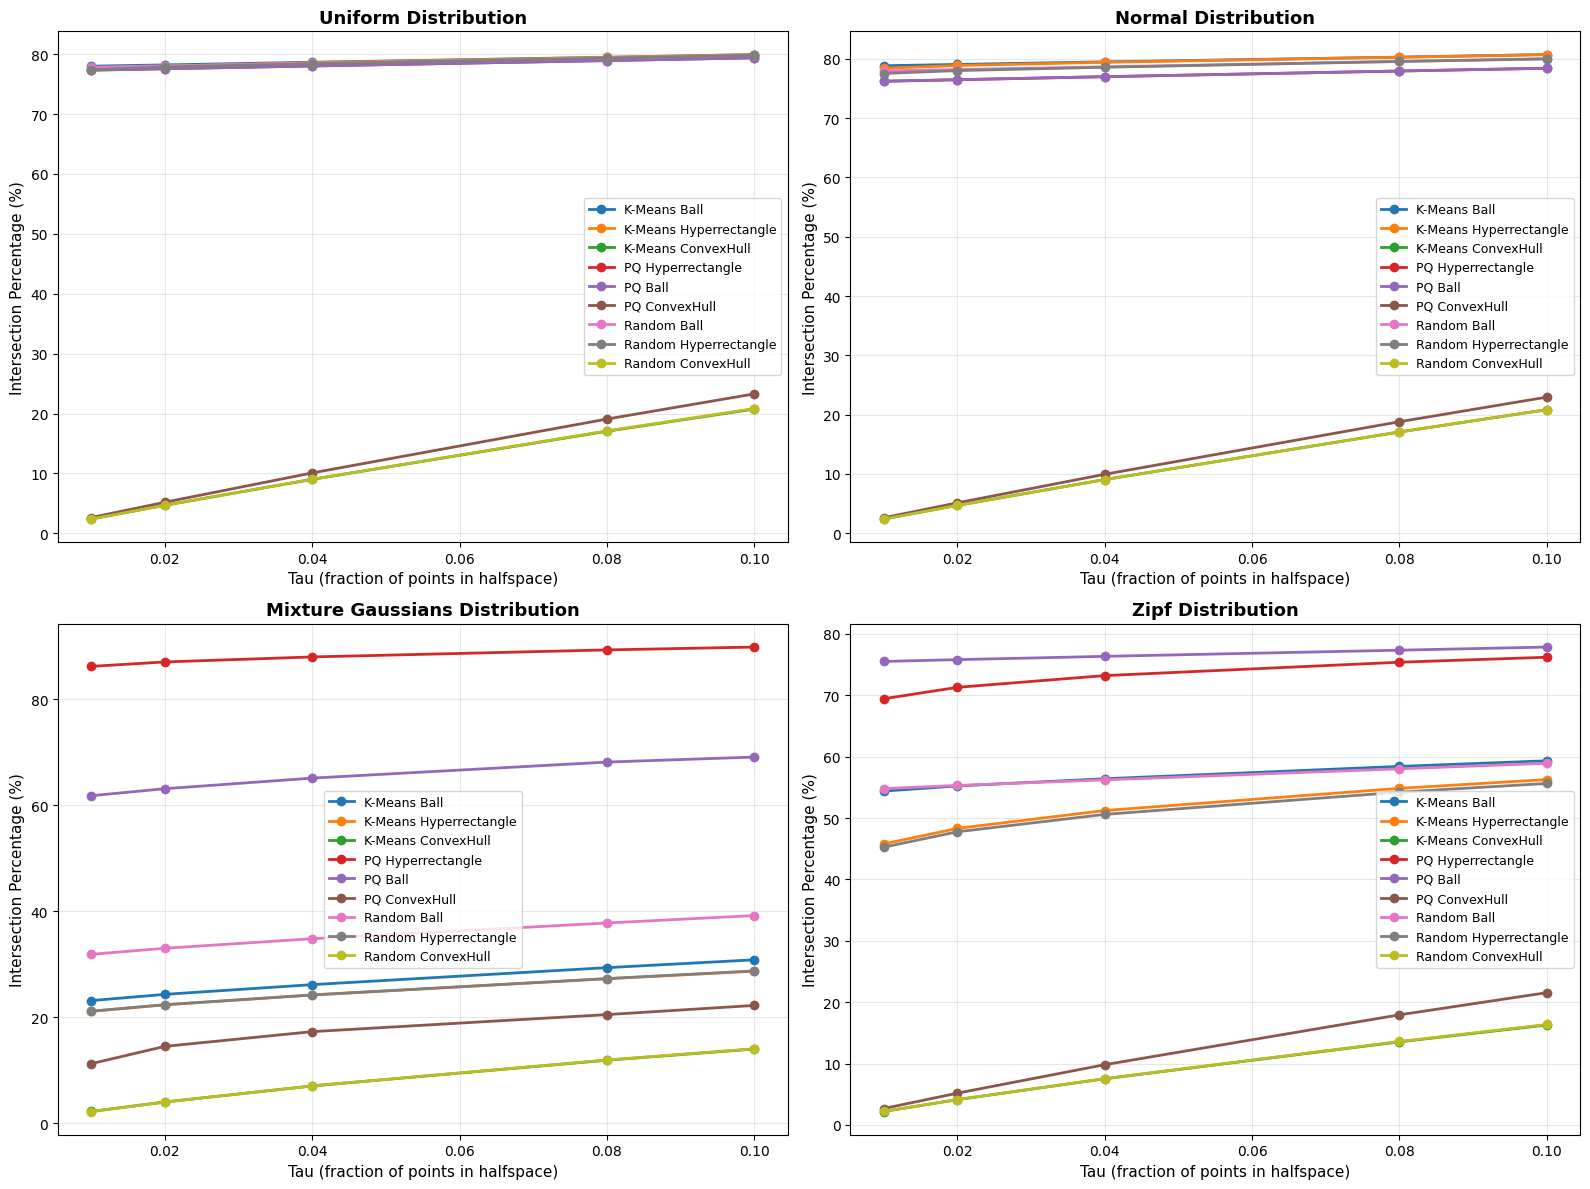

In [9]:
# Plot 1: Mean intersection percentage vs tau for each distribution (separate subplots)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, dist in enumerate(DISTRIBUTIONS):
    ax = axes[idx]
    results = all_results[dist]
    
    for index_name in index_types:
        means = [np.mean(results[index_name][tau]) for tau in TAU_VALUES]
        stds = [np.std(results[index_name][tau]) for tau in TAU_VALUES]
        
        ax.plot(TAU_VALUES, means, marker='o', label=index_name, linewidth=2)
        # ax.fill_between(TAU_VALUES, 
                        #  np.array(means) - np.array(stds),
                        #  np.array(means) + np.array(stds),
                        #  alpha=0.2)
    
    ax.set_xlabel('Tau (fraction of points in halfspace)', fontsize=11)
    ax.set_ylabel('Intersection Percentage (%)', fontsize=11)
    ax.set_title(f"{dist.replace('_', ' ').title()} Distribution", fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig(FIGURES_DIR / 'intersection_vs_tau.png', dpi=300, bbox_inches='tight')
plt.show()


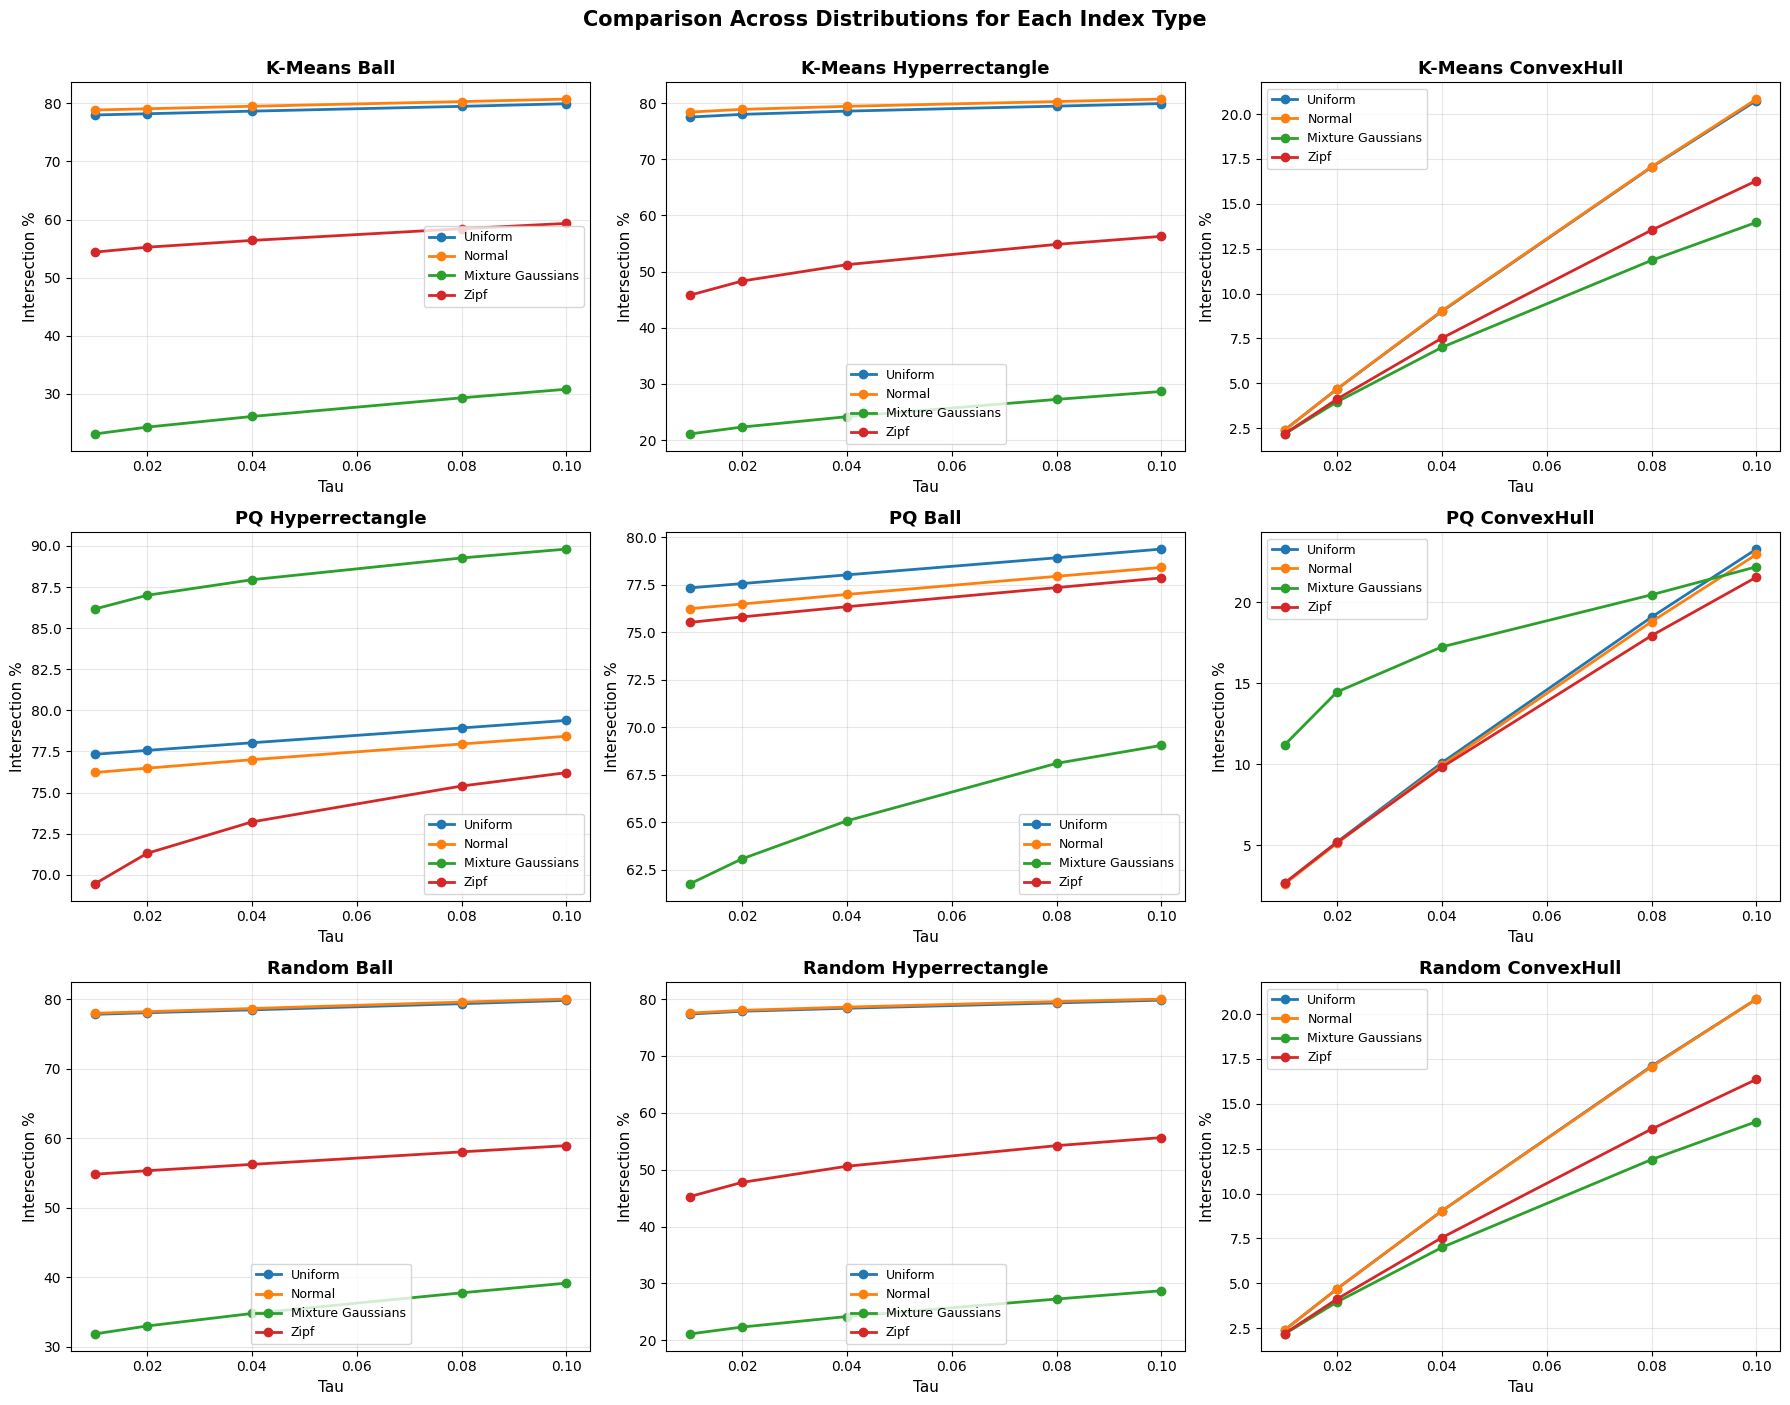

In [10]:
# Plot 2: Comparison across distributions for each index type
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for idx, index_name in enumerate(index_types):
    ax = axes[idx]
    
    for dist in DISTRIBUTIONS:
        results = all_results[dist]
        means = [np.mean(results[index_name][tau]) for tau in TAU_VALUES]
        ax.plot(TAU_VALUES, means, marker='o', label=dist.replace('_', ' ').title(), linewidth=2)
    
    ax.set_xlabel('Tau', fontsize=11)
    ax.set_ylabel('Intersection %', fontsize=11)
    ax.set_title(f'{index_name}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Comparison Across Distributions for Each Index Type', fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


## Convex Hull Comparison

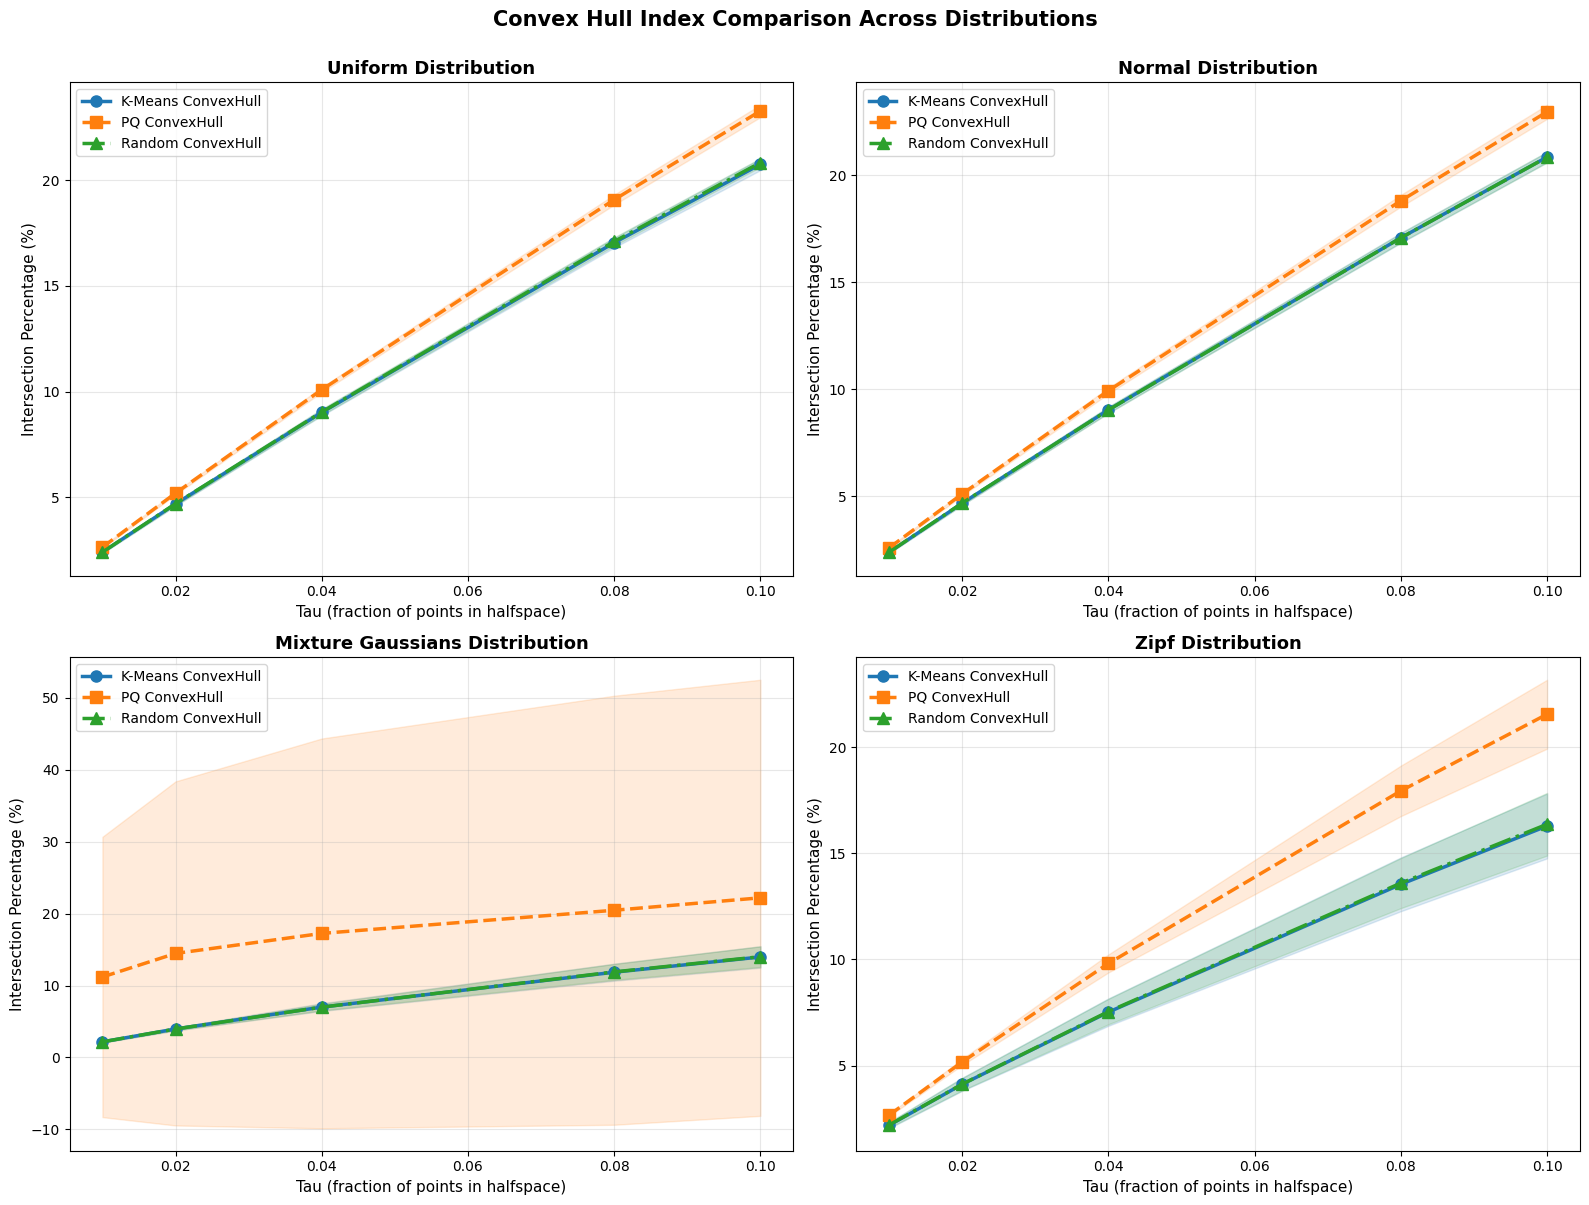

In [12]:
# Plot 3: Convex Hull indexes comparison across distributions
convexhull_indexes = ['K-Means ConvexHull', 'PQ ConvexHull', 'Random ConvexHull']

# Define distinct styles for each index
styles = {
    'K-Means ConvexHull': {'linestyle': '-', 'color': 'C0', 'marker': 'o'},
    'PQ ConvexHull': {'linestyle': '--', 'color': 'C1', 'marker': 's'},
    'Random ConvexHull': {'linestyle': '-.', 'color': 'C2', 'marker': '^'}
}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, dist in enumerate(DISTRIBUTIONS):
    ax = axes[idx]
    results = all_results[dist]
    
    for index_name in convexhull_indexes:
        means = [np.mean(results[index_name][tau]) for tau in TAU_VALUES]
        stds = [np.std(results[index_name][tau]) for tau in TAU_VALUES]
        
        style = styles[index_name]
        ax.plot(TAU_VALUES, means, 
                label=index_name, 
                linewidth=2.5, 
                markersize=8,
                linestyle=style['linestyle'],
                color=style['color'],
                marker=style['marker'])
        ax.fill_between(TAU_VALUES, 
                         np.array(means) - np.array(stds),
                         np.array(means) + np.array(stds),
                         alpha=0.15,
                         color=style['color'])
    
    ax.set_xlabel('Tau (fraction of points in halfspace)', fontsize=11)
    ax.set_ylabel('Intersection Percentage (%)', fontsize=11)
    ax.set_title(f"{dist.replace('_', ' ').title()} Distribution", fontsize=13, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)

plt.suptitle('Convex Hull Index Comparison Across Distributions', fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
fig.savefig(FIGURES_DIR / 'convexhull_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Real Keys

Run this part separately.

In [4]:
# In your experiment.py or test scripts
import sys
sys.path.append('/home/mohsen/kvcache/hira/tests/kv_sampling')
from load_kv_data import load_kv_data

# Instead of generating synthetic data:
# keys = torch.randn(NUM_KEYS, DIMENSION)

# Use real data:
keys, queries = load_kv_data(
    # '/home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_*.csv',
    '/home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Llama-3.2-1B_needle_4096_20251215_085806.csv',
    layer_idx=0,
    max_keys=NUM_KEYS
)

Loading KV data from /home/mohsen/kvcache/hira/tests/kv_sampling/kv_data/kv_data_Llama-3.2-1B_needle_4096_20251215_085806.csv
Layer: 0
Total rows for layer 0: 1136128
Loading 10000 keys...
Loading 3200 queries...
Keys shape: torch.Size([10000, 64])
Queries shape: torch.Size([3200, 64])


In [5]:
# Check real data properties vs synthetic
print("="*60)
print("Data Comparison: Real vs Synthetic")
print("="*60)

print("\nREAL DATA:")
print(f"  Shape: {keys.shape}")
print(f"  Dtype: {keys.dtype}")
print(f"  Mean: {keys.mean():.6f}")
print(f"  Std: {keys.std():.6f}")
print(f"  Min: {keys.min():.6f}")
print(f"  Max: {keys.max():.6f}")
print(f"  Norm (first 100): {torch.norm(keys[:100], dim=1).mean():.6f}")


Data Comparison: Real vs Synthetic

REAL DATA:
  Shape: torch.Size([10000, 64])
  Dtype: torch.float32
  Mean: 0.156262
  Std: 1.942056
  Min: -10.350000
  Max: 13.590000
  Norm (first 100): 13.072696


In [12]:
# Build indexes for real data
print(f"\n{'='*60}")
print("Building indexes for REAL data from Llama 3.2...")
print('='*60)

# Exclude convex hull indexes that crash with large point sets
exclude_list = ['PQ ConvexHull']
real_indexes = build_indexes(keys, exclude_indexes=exclude_list)

if 'K-Means Ball' in real_indexes:
    print(f"  K-Means Ball: {len(real_indexes['K-Means Ball'].balls)} balls")
if 'K-Means Hyperrectangle' in real_indexes:
    print(f"  K-Means Hyperrectangle: {len(real_indexes['K-Means Hyperrectangle'].hyperrectangles)} hyperrectangles")
if 'K-Means ConvexHull' in real_indexes:
    print(f"  K-Means ConvexHull: {len(real_indexes['K-Means ConvexHull'].convex_hulls)} hulls")
if 'PQ Hyperrectangle' in real_indexes:
    print(f"  PQ Hyperrectangle: {len(real_indexes['PQ Hyperrectangle'].hyperrectangles)} hyperrectangles")
if 'PQ Ball' in real_indexes:
    print(f"  PQ Ball: {len(real_indexes['PQ Ball'].balls)} balls")
if 'PQ ConvexHull' in real_indexes:
    print(f"  PQ ConvexHull: {len(real_indexes['PQ ConvexHull'].convex_hulls)} hulls")
if 'Random Ball' in real_indexes:
    print(f"  Random Ball: {len(real_indexes['Random Ball'].balls)} balls")
if 'Random Hyperrectangle' in real_indexes:
    print(f"  Random Hyperrectangle: {len(real_indexes['Random Hyperrectangle'].hyperrectangles)} hyperrectangles")
if 'Random ConvexHull' in real_indexes:
    print(f"  Random ConvexHull: {len(real_indexes['Random ConvexHull'].convex_hulls)} hulls")

# Prepare real sampled queries (normalize them to unit vectors for halfspace tests)
print(f"\n{'='*60}")
print(f"Sampling 50 queries from {len(queries)} real queries...")
print('='*60)

# Shuffle and sample 50 queries
num_sample = min(50, len(queries))
indices = torch.randperm(len(queries))[:num_sample]
sampled_queries = []
for idx in indices:
    q = queries[idx]
    # Normalize to unit vector
    q_normalized = q / torch.norm(q)
    sampled_queries.append(q_normalized)

print(f"Normalized {len(sampled_queries)} randomly sampled queries for halfspace testing")


Building indexes for REAL data from Llama 3.2...
Building 9 indexes...
Excluding: PQ ConvexHull
Keys shape: torch.Size([10000, 64])

[1/9] Building K-Means Ball Index...


WARNING clustering 10000 points to 4000 centroids: please provide at least 156000 training points


  ✓ Done in 2.41s
[2/9] Building K-Means Hyperrectangle Index...


WARNING clustering 10000 points to 4000 centroids: please provide at least 156000 training points


  ✓ Done in 2.31s
[3/9] Building K-Means ConvexHull Index...


WARNING clustering 10000 points to 4000 centroids: please provide at least 156000 training points


  ✓ Done in 2.30s
[4/9] Building PQ Hyperrectangle Index...
  ✓ Done in 0.03s
[5/9] Building PQ Ball Index...
Number of unique PQ codes (balls): 140
  ✓ Done in 0.03s
[6/9] Skipping PQ ConvexHull Index
[7/9] Building Random Ball Index...
  ✓ Done in 0.08s
[8/9] Building Random Hyperrectangle Index...
  ✓ Done in 0.16s
[9/9] Building Random ConvexHull Index...
  ✓ Done in 0.10s

✓ All 9 indexes built successfully!
  K-Means Ball: 4000 balls
  K-Means Hyperrectangle: 4000 hyperrectangles
  K-Means ConvexHull: 4000 hulls
  PQ Hyperrectangle: 140 hyperrectangles
  PQ Ball: 140 balls
  Random Ball: 4000 balls
  Random Hyperrectangle: 4000 hyperrectangles
  Random ConvexHull: 4000 hulls

Sampling 50 queries from 3200 real queries...
Normalized 50 randomly sampled queries for halfspace testing


In [14]:
# Run intersection tests on real data with real sampled queries
print(f"\n{'='*60}")
print("Running intersection tests with REAL SAMPLED QUERIES...")
print('='*60)

# Define all possible index types
index_types = [
    'K-Means Ball', 'K-Means Hyperrectangle', 'K-Means ConvexHull',
    'PQ Hyperrectangle', 'PQ Ball', #'PQ ConvexHull',
    'Random Ball', 'Random Hyperrectangle', 'Random ConvexHull'
]

# Only test indexes that were actually built
available_index_types = [idx for idx in index_types if idx in real_indexes]
print(f"Available indexes: {available_index_types}")

real_results = {idx: {tau: [] for tau in TAU_VALUES} for idx in available_index_types}


for tau in TAU_VALUES:
    print(f"  Testing tau = {tau:.2f}...")
    
    for q in sampled_queries:
        # Compute threshold for this tau
        threshold = compute_threshold_for_tau(keys, q, tau)
        
        # Test all available indexes
        for index_name in available_index_types:
            pct = real_indexes[index_name].get_intersection_percentage(q, threshold)
            real_results[index_name][tau].append(pct)

print(f"\n{'='*60}")
print("Testing complete for real data with real queries!")
print('='*60)

# Compute statistics for real data
real_stats = []

for index_name in available_index_types:
    for tau in TAU_VALUES:
        percentages = real_results[index_name][tau]
        mean_pct = np.mean(percentages)
        std_pct = np.std(percentages)
        min_pct = np.min(percentages)
        max_pct = np.max(percentages)
        
        real_stats.append({
            'Index': index_name,
            'Tau': tau,
            'Mean (%)': mean_pct,
            'Std (%)': std_pct,
            'Min (%)': min_pct,
            'Max (%)': max_pct
        })

real_stats_df = pd.DataFrame(real_stats)

print(f"\n{'='*80}")
print("Statistics for REAL DATA (Llama 3.2 KV Cache with Real Queries):")
print('='*80)
print(real_stats_df.to_string(index=False))



Running intersection tests with REAL SAMPLED QUERIES...
Available indexes: ['K-Means Ball', 'K-Means Hyperrectangle', 'K-Means ConvexHull', 'PQ Hyperrectangle', 'PQ Ball', 'Random Ball', 'Random Hyperrectangle', 'Random ConvexHull']
  Testing tau = 0.01...
  Testing tau = 0.02...
  Testing tau = 0.04...
  Testing tau = 0.08...
  Testing tau = 0.10...

Testing complete for real data with real queries!

Statistics for REAL DATA (Llama 3.2 KV Cache with Real Queries):
                 Index  Tau  Mean (%)   Std (%)   Min (%)   Max (%)
          K-Means Ball 0.01  1.002500  0.080351  0.800000  1.175000
          K-Means Ball 0.02  2.025500  0.116242  1.850000  2.325000
          K-Means Ball 0.04  4.022500  0.136862  3.800000  4.375000
          K-Means Ball 0.08  8.089000  0.278978  7.525000  8.575000
          K-Means Ball 0.10 10.059500  0.314559  9.500000 10.500000
K-Means Hyperrectangle 0.01  0.965000  0.082462  0.800000  1.150000
K-Means Hyperrectangle 0.02  1.980500  0.110938  1.82


Average Intersection Percentages Across All Tau Values (sorted):
K-Means ConvexHull            :   4.99%
K-Means Hyperrectangle        :   5.00%
K-Means Ball                  :   5.04%
Random ConvexHull             :   5.06%
Random Hyperrectangle         :   5.50%
Random Ball                   :   7.68%
PQ Hyperrectangle             :  39.27%
PQ Ball                       :  54.73%


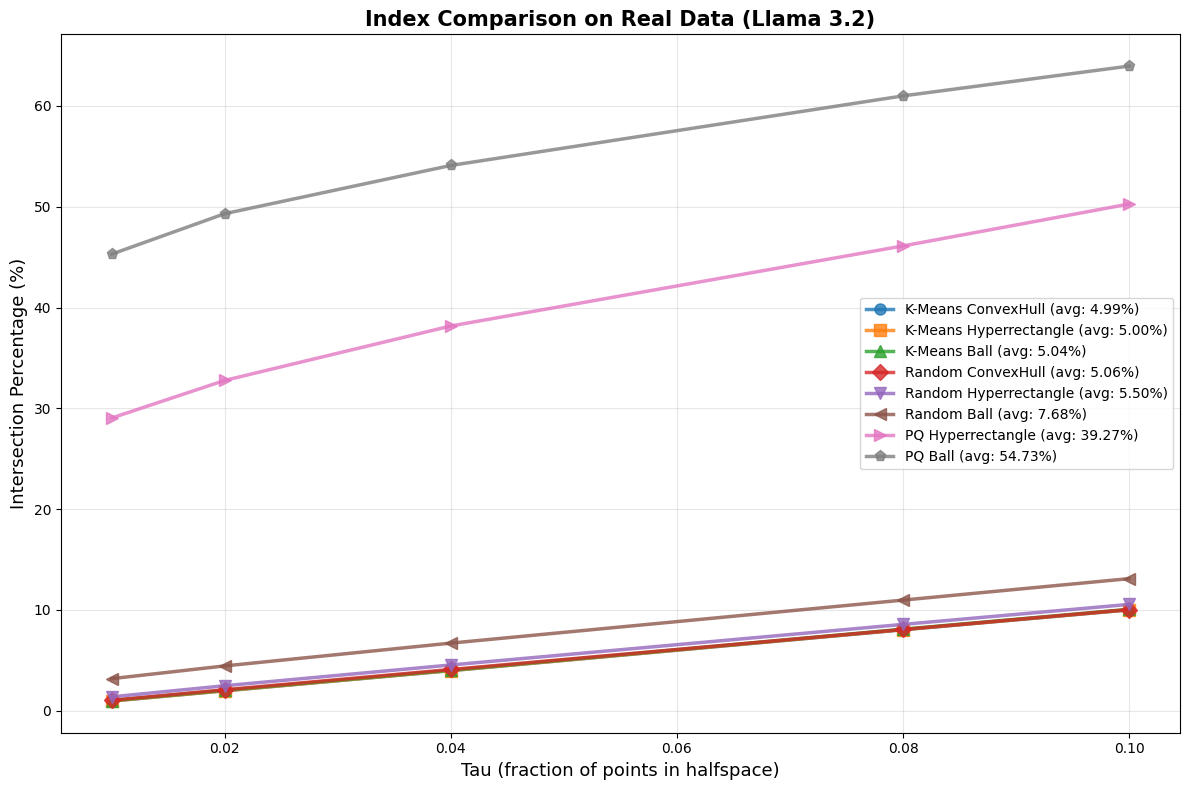


✓ Saved index comparison plot to: figures/real_data_index_comparison.png


In [20]:
# Additional plot: Compare all indexes on a single plot
fig2, ax2 = plt.subplots(1, 1, figsize=(12, 8))

# Plot each index type with different style
colors = plt.cm.tab10(range(len(available_index_types)))
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p', '*']

# Calculate average percentages and sort
index_averages = []
for index_name in available_index_types:
    means_real = [np.mean(real_results[index_name][tau]) for tau in TAU_VALUES]
    avg_across_all_tau = np.mean(means_real)
    index_averages.append((index_name, avg_across_all_tau, means_real))

# Sort by average percentage (ascending)
index_averages.sort(key=lambda x: x[1])

# Print sorted average percentages
print(f"\n{'='*80}")
print("Average Intersection Percentages Across All Tau Values (sorted):")
print('='*80)

for index_name, avg_across_all_tau, _ in index_averages:
    print(f"{index_name:30s}: {avg_across_all_tau:6.2f}%")

print('='*80)

# Plot all indexes
for idx, (index_name, avg_across_all_tau, means_real) in enumerate(index_averages):
    ax2.plot(TAU_VALUES, means_real, 
             marker=markers[idx % len(markers)], 
             label=f"{index_name} (avg: {avg_across_all_tau:.2f}%)",
             linewidth=2.5, 
             markersize=8,
             color=colors[idx],
             alpha=0.8)

ax2.set_xlabel('Tau (fraction of points in halfspace)', fontsize=13)
ax2.set_ylabel('Intersection Percentage (%)', fontsize=13)
ax2.set_title('Index Comparison on Real Data (Llama 3.2)', fontsize=15, fontweight='bold')
ax2.legend(fontsize=10, loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
fig2.savefig(FIGURES_DIR / 'real_data_index_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Saved index comparison plot to: {FIGURES_DIR / 'real_data_index_comparison.png'}")